In [1]:
# Importing required libraries and functions
import wandb
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import datetime
import tensorflow as tf
import random

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LSTM

In [2]:
sns.set_theme()

In [3]:
# To log into wandb
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("WANDB_API_KEY")

In [4]:
# setting the wandb API from Kaggle secrets to avoid manual login
os.environ["WANDB_API_KEY"] = secret_value_0

# uncomment below line for dry run of wandb
# os.environ["WANDB_MODE"] = 'dryrun'

In [5]:
if 'WANDB_MODE' in os.environ and os.environ['WANDB_MODE'] == 'dryrun':
    # not really  a dry run, as we need to authenticate
    # and get the artifact
    api = wandb.Api()
    artifact1 = api.artifact('ml-major-project-g3/major-project/covid19-uk-processed-dataset:latest')
else:
    # starting a run on project, entity(team)
    run = wandb.init(entity='ml-major-project-g3', project='major-project',
                 job_type='model_creation_and_prediction', save_code=True)
    artifact1 = run.use_artifact('covid19-uk-processed-dataset:latest')

artifact_dir1 = artifact1.download()


wandb: Currently logged in as: ml-major-project-g3 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.28 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [6]:
!ls artifacts/covid19-uk-processed-dataset:v1

uk_processed.csv


In [7]:
# WandB configuration for logging the model
cfg = wandb.config
cfg.model_type = 'LSTM_Regression'
cfg.TEST_START_DATE = '2021-01-01'
cfg.TEST_END_DATE = '2021-04-06'
cfg.train_val_split = 0.15
cfg.dropped_features = []
cfg.RANDOM_SEED = 42
cfg.num_future_days = 14
cfg.num_past_days = 30
cfg.batch_size = 2
cfg.num_epochs = 75
cfg.es_patience = 30
cfg.criterion = 'mse'
cfg.pred_var = 'new_deaths_smoothed'


In [8]:
# Dataset we'll be using
ori_df = pd.read_csv("artifacts/covid19-uk-processed-dataset:v1/uk_processed.csv")

In [9]:
# Show all columns, max 20 rows
pd.set_option('display.max_columns', None, 'display.max_rows', 20)

In [10]:
ori_df.head(50)

,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,hospital_beds_per_thousand,life_expectancy,human_development_index,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,H6_Facial Coverings,H6_Flag,H7_Vaccination policy,H7_Flag,H8_Protection of elderly people,H8_Flag,StringencyIndex,StringencyIndexForDisplay,StringencyLegacyIndex,StringencyLegacyIndexForDisplay,GovernmentResponseIndex,GovernmentResponseIndexForDisplay,ContainmentHealthIndex,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay
0,2020-01-31,2.0,2.0,0.285714,0.0,0.0,0.000,0.029,0.029,0.004209,0.000,0.000,0.000,0.000000,0.000000,0.000000,0.000000,5.000000,5.000000,0.000074,0.000074,0.714286,0.000011,2.800000,0.357143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.33,67886004.0,272.898,40.8,18.517,12.527,39753.244,0.2,122.137,4.28,20.0,24.7,2.54,81.32,0.932,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.000000e+00,0.0,2.0,0.0,1.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,8.33,8.33,9.52,9.52,13.02,13.02,14.88,14.88,0.0,0.0
1,2020-02-01,2.0,0.0,0.285714,0.0,0.0,0.000,0.029,0.000,0.004209,0.000,0.000,0.000,0.000000,0.000000,0.000000,0.000000,0.940653,5.940653,0.000088,0.000014,0.848665,0.000013,2.800000,0.357143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.33,67886004.0,272.898,40.8,18.517,12.527,39753.244,0.2,122.137,4.28,20.0,24.7,2.54,81.32,0.932,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.000000e+00,0.0,2.0,0.0,1.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,8.33,8.33,9.52,9.52,13.02,13.02,14.88,14.88,0.0,0.0
2,2020-02-02,2.0,0.0,0.285714,0.0,0.0,0.000,0.029,0.000,0.004209,0.000,0.000,0.000,0.000000,0.000000,0.000000,0.000000,1.117618,7.058271,0.000104,0.000016,1.008324,0.000015,2.800000,0.357143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.11,67886004.0,272.898,40.8,18.517,12.527,39753.244,0.2,122.137,4.28,20.0,24.7,2.54,81.32,0.932,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.000000e+00,0.0,2.0,1.0,1.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,11.11,11.11,14.29,14.29,14.58,14.58,16.67,16.67,0.0,0.0
3,2020-02-03,8.0,6.0,1.142857,0.0,0.0,0.000,0.118,0.088,0.016835,0.000,0.000,0.000,0.000000,0.000000,0.000000,0.000000,1.327876,8.386147,0.000124,0.000020,1.198021,0.000018,2.572288,0.388759,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.11,67886004.0,272.898,40.8,18.517,12.527,39753.244,0.2,122.137,4.28,20.0,24.7,2.54,81.32,0.932,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.000000e+00,0.0,2.0,1.0,1.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,11.11,11.11,14.29,14.29,14.58,14.58,16.67,16.67,0.0,0.0
4,2020-02-04,8.0,0.0,1.142857,0.0,0.0,0.000,0.118,0.000,0.016835,0.000,0.000,0.000,0.000000,0.000000,0.000000,0.000000,1.577690,9.963837,0.000147,0.000023,1.423405,0.000021,2.572288,0.388759,0.0,0

In [11]:
# Get information for all columns
ori_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432 entries, 0 to 431
Data columns (total 89 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   date                                   432 non-null    object 
 1   total_cases                            432 non-null    float64
 2   new_cases                              432 non-null    float64
 3   new_cases_smoothed                     432 non-null    float64
 4   total_deaths                           432 non-null    float64
 5   new_deaths                             432 non-null    float64
 6   new_deaths_smoothed                    432 non-null    float64
 7   total_cases_per_million                432 non-null    float64
 8   new_cases_per_million                  432 non-null    float64
 9   new_cases_smoothed_per_million         432 non-null    float64
 10  total_deaths_per_million               432 non-null    float64
 11  new_de

In [12]:
# for reproducibility
np.random.seed(cfg.RANDOM_SEED)
random.seed(cfg.RANDOM_SEED)
tf.random.set_seed(cfg.RANDOM_SEED)


In [13]:
# convert 'date' to datetime type
ori_df['date'] = pd.to_datetime(ori_df['date'], format='%Y-%m-%d')

In [14]:
# Check if all dates are in increasing order (later date  is set as index)
ori_df['date'].is_monotonic_increasing

True

In [15]:
# Adding engineered features

def add_engineered_features(df, first_time=True):
    df['susceptible_population'] = ori_df['population'] - df['people_vaccinated'] - df['total_cases']
    df['icu_fatality'] = df['new_deaths_smoothed']/df['icu_patients']
    df['icu_hosp_ratio'] = df['icu_patients']/df['hosp_patients']
    df['hosp_beds_left'] = (df['hospital_beds_per_thousand']*df['population']/1000) - df['hosp_patients']
    df['potential_cases'] = df['susceptible_population'] * df['positive_rate']
    return df

ori_df = add_engineered_features(ori_df)

In [16]:
# Remove rows that have nan values in them

def_values = {'icu_fatality':0, 'icu_hosp_ratio':0}
ori_df.fillna(def_values, inplace=True)
ori_df.dropna(inplace=True)

In [17]:
columns_to_take = ['date', 'new_cases_smoothed','new_deaths_smoothed','icu_fatality',#'susceptible_population', 'total_cases', 
                    'hosp_beds_left', 'potential_cases','icu_hosp_ratio',#'total_vaccinations', 'total_deaths',
                   'icu_patients', #'people_vaccinated_per_hundred',
                   'hosp_patients',#'total_tests',
                  'C1_School closing', 'C2_Workplace closing', 'C3_Cancel public events','C4_Restrictions on gatherings', 'C5_Close public transport',
                  'C6_Stay at home requirements','C7_Restrictions on internal movement', 'C8_International travel controls']

cfg.dropped_features = list(ori_df.columns.difference(columns_to_take))
compact_df = ori_df.drop(ori_df.columns.difference(columns_to_take), axis=1)

compact_df.set_index('date', inplace=True)

In [18]:
compact_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 432 entries, 2020-01-31 to 2021-04-06
Data columns (total 16 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   new_cases_smoothed                    432 non-null    float64
 1   new_deaths_smoothed                   432 non-null    float64
 2   icu_patients                          432 non-null    float64
 3   hosp_patients                         432 non-null    float64
 4   C1_School closing                     432 non-null    float64
 5   C2_Workplace closing                  432 non-null    float64
 6   C3_Cancel public events               432 non-null    float64
 7   C4_Restrictions on gatherings         432 non-null    float64
 8   C5_Close public transport             432 non-null    float64
 9   C6_Stay at home requirements          432 non-null    float64
 10  C7_Restrictions on internal movement  432 non-null    float64
 11  

In [19]:
# Some important parameters

last_n_days = cfg.num_past_days
next_k_days = cfg.num_future_days
num_epochs = cfg.num_epochs
batch_size = cfg.batch_size
train_val_split = cfg.train_val_split
target_var = cfg.pred_var

In [20]:
compact_df

,new_cases_smoothed,new_deaths_smoothed,icu_patients,hosp_patients,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,C7_Restrictions on internal movement,C8_International travel controls,icu_fatality,icu_hosp_ratio,hosp_beds_left,potential_cases
date,,,,,,,,,,,,,,,,
2020-01-31,0.285714,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,172430.45016,1.900808e+08
2020-02-01,0.285714,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,172430.45016,1.900808e+08
2020-02-02,0.285714,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,172430.45016,1.900808e+08
2020-02-03,1.142857,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,172430.45016,1.746223e+08
2020-02-04,1.142857,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,172430.45016,1.746223e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-02,4116.000000,43.286,485.0,3362.0,2.0,3.0,2.0,4.0,1.0,2.0,2.0,3.0,0.089249,0.144259,169068.45016,1.413147e+05
2021-04-03,4046.714000,36.429,478.0,3230.0,2.0,3.0,2.0,4.0,1.0,2.0,2.0,3.0,0.076211,0.147988,169200.45016,1.410115e+05
2021-04-04,3826.429000,34.857,469.0,3212.0,2.0,3.0,2.0,4.0,1.0,2.0,2.0,3.0,0.074322,0.146015,169218.45016,1.480306e+05


In [21]:

trainx_data_start = compact_df.index[0] 
trainx_data_end = datetime.datetime(2020, 12, 31) - datetime.timedelta(days=next_k_days+(last_n_days-1))

valx_data_end = datetime.datetime(2020, 12, 31) - datetime.timedelta(days=next_k_days+(last_n_days-1))
valx_data_start = valx_data_end - datetime.timedelta(days = int((trainx_data_end-trainx_data_start).days * train_val_split))

trainx_data_end = valx_data_start - datetime.timedelta(days=1)

testx_data_start = datetime.datetime(2021, 1, 1) - datetime.timedelta(days=last_n_days)
testx_data_end = compact_df.index[-1] - datetime.timedelta(days=next_k_days+(last_n_days-1))

print(trainx_data_start, trainx_data_end)
print(valx_data_start, valx_data_end)
print(testx_data_start, testx_data_end)


# print(f"{ori_df.shape}")
# print(f"{train_df.shape}")
# print(f"{test_df.shape}")

# Scale all data and store scalers separately
scaler_dict = {}
for column in compact_df.columns:
    new_scaler = MinMaxScaler(feature_range=(0,1))
    # 
    ser = np.reshape(compact_df[compact_df.index < valx_data_end + datetime.timedelta(days=last_n_days-1)][column].values, (-1, 1))
    new_scaler.fit(ser)
    scaler_dict[column] = new_scaler

for column in compact_df.columns:
    ser = np.reshape(compact_df[column].values, (-1, 1))
    new_ser = np.reshape(scaler_dict[column].transform(ser), (-1))
    compact_df[column] = new_ser

compact_df.tail(45)
    



2020-01-31 00:00:00 2020-10-05 00:00:00
2020-10-06 00:00:00 2020-11-18 00:00:00
2020-12-02 00:00:00 2021-02-22 00:00:00


,new_cases_smoothed,new_deaths_smoothed,icu_patients,hosp_patients,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,C7_Restrictions on internal movement,C8_International travel controls,icu_fatality,icu_hosp_ratio,hosp_beds_left,potential_cases
date,,,,,,,,,,,,,,,,
2021-02-21,0.437350,0.518401,0.705544,0.777378,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.5,0.564195,0.743862,0.222622,0.004271
2021-02-22,0.442324,0.509768,0.688579,0.777332,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.5,0.568468,0.726019,0.222668,0.004048
2021-02-23,0.430423,0.471755,0.651015,0.743210,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.5,0.556434,0.717926,0.256790,0.003751
2021-02-24,0.414579,0.427078,0.641624,0.716420,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.5,0.511111,0.734029,0.283580,0.003434
2021-02-25,0.402893,0.407239,0.620115,0.684834,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.5,0.504272,0.742143,0.315166,0.003175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-02,0.162263,0.045889,0.146925,0.155024,0.666667,1.0,1.0,1.0,1.0,1.0,1.0,1.5,0.239826,0.776781,0.844976,0.000542
2021-04-03,0.159532,0.038619,0.144805,0.148937,0.666667,1.0,1.0,1.0,1.0,1.0,1.0,1.5,0.204790,0.796856,0.851063,0.000541
2021-04-04,0.150847,0.036953,0.142078,0.148107,0.666667,1.0,1.0,1.0,1.0,1.0,1.0,1.5,0.199713,0.786234,0.851893,0.000572


In [22]:
def change_stringency(df, make_max=True):
    columns_to_consider = [x for x in df.columns if x.startswith('C')]
    max_vals = {'C1':3, 'C2':3, 'C3':2, 'C4':4, 'C5':2, 'C6':3, 'C7':2, 'C8':4}
    
    for column in columns_to_consider:
        if make_max:
            df.loc[:,column] = max_vals[column[:2]]
        else:
            df.loc[:,column] = 0
        
        ser = np.reshape(df[column].values, (-1, 1))
        new_ser = np.reshape(scaler_dict[column].transform(ser), (-1))
        df.loc[:,column] = new_ser
        

In [23]:
# Perform train-test split

trainX = []
trainy = []
valX = []
valy = []
testX = []
train_stringency_max = []
train_stringency_min = []
testy = []
train_y_dates = pd.date_range(start=trainx_data_start + datetime.timedelta(days=last_n_days), end=trainx_data_end + datetime.timedelta(days=last_n_days+next_k_days-1))
val_y_dates = pd.date_range(start=valx_data_start + datetime.timedelta(days=last_n_days), end=valx_data_end + datetime.timedelta(days=last_n_days+next_k_days-1))
test_y_dates = pd.date_range(start=testx_data_start + datetime.timedelta(days=last_n_days), end=testx_data_end + datetime.timedelta(days=last_n_days+next_k_days-1))

x_data_start = trainx_data_start
while x_data_start <= valx_data_end:
    datapoint_df = compact_df[(compact_df.index >= x_data_start) & (compact_df.index <= x_data_start + datetime.timedelta(days=last_n_days-1))].copy(deep=True)
    datapoint_ori = datapoint_df.values
    change_stringency(datapoint_df, make_max=True)
    datapoint_max_stringency = datapoint_df.values
    change_stringency(datapoint_df, make_max=False)
    datapoint_min_stringency = datapoint_df.values
    target = compact_df[(compact_df.index >= x_data_start + datetime.timedelta(days=last_n_days)) & (compact_df.index <= x_data_start + datetime.timedelta(days=last_n_days+next_k_days-1))][target_var].values
    
    if x_data_start <= trainx_data_end:
        trainX.append(datapoint_ori)
        train_stringency_max.append(datapoint_max_stringency)
        train_stringency_min.append(datapoint_min_stringency)
        trainy.append(target)
        
    else:
        valX.append(datapoint_ori)
        valy.append(target)
    
    x_data_start += datetime.timedelta(days=1)
    
x_data_start = testx_data_start
while x_data_start <= testx_data_end:
    datapoint = compact_df[(compact_df.index >= x_data_start) & (compact_df.index <= x_data_start + datetime.timedelta(days=last_n_days-1))].values
    target = compact_df[(compact_df.index >= x_data_start + datetime.timedelta(days=last_n_days)) & (compact_df.index <= x_data_start + datetime.timedelta(days=last_n_days+next_k_days-1))][target_var].values
    
    testX.append(datapoint)
    testy.append(target)
    
    x_data_start += datetime.timedelta(days=1)

    
trainX = np.array(trainX)
trainy = np.array(trainy)
train_stringency_max = np.array(train_stringency_max)
train_stringency_min = np.array(train_stringency_min)
valX = np.array(valX)
valy = np.array(valy)
testX = np.array(testX)
testy = np.array(testy)
    

# print(testX[-1,:,:])
# print(testy[-1])
print(trainX.shape, trainy.shape)
print(valX.shape, valy.shape)
print(testX.shape, testy.shape)
print("train_y_dates shape is",len(train_y_dates), "start date:",train_y_dates[0], "end date:", train_y_dates[-1])
print("val_y_dates shape is",len(val_y_dates), "start date:",val_y_dates[0], "end date:", val_y_dates[-1])
print("test_y_dates shape is",len(test_y_dates), "start date:",test_y_dates[0], "end date:", test_y_dates[-1])

(249, 30, 16) (249, 14)
(44, 30, 16) (44, 14)
(83, 30, 16) (83, 14)
train_y_dates shape is 262 start date: 2020-03-01 00:00:00 end date: 2020-11-17 00:00:00
val_y_dates shape is 57 start date: 2020-11-05 00:00:00 end date: 2020-12-31 00:00:00
test_y_dates shape is 96 start date: 2021-01-01 00:00:00 end date: 2021-04-06 00:00:00


In [24]:

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta = 0.001, patience=cfg.es_patience, restore_best_weights=True)
# design network
model = Sequential()
model.add(LSTM(64, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.3))
# model.add(LSTM(32))
# model.add(Dropout(0.3))
# model.add(LSTM(50))
# model.add(Dropout(0.3))
model.add(Dense(2*next_k_days))
model.add(Dropout(0.3))
model.add(Dense(next_k_days))
model.compile(loss='mse', optimizer='adam')
# fit network

# initial wieghts
initial_weights = model.get_weights()
history = model.fit(trainX, trainy, epochs=num_epochs, batch_size=batch_size, validation_data=(valX, valy), verbose=1, shuffle=True, callbacks=[es_callback])

Epoch 1/75
125/125 [==============================] - 6s 13ms/step - loss: 0.1152 - val_loss: 0.0462
Epoch 2/75
125/125 [==============================] - 1s 6ms/step - loss: 0.0360 - val_loss: 0.0516
Epoch 3/75
125/125 [==============================] - 1s 6ms/step - loss: 0.0199 - val_loss: 0.0760
Epoch 4/75
125/125 [==============================] - 1s 6ms/step - loss: 0.0217 - val_loss: 0.0642
Epoch 5/75
125/125 [==============================] - 1s 6ms/step - loss: 0.0125 - val_loss: 0.0345
Epoch 6/75
125/125 [==============================] - 1s 6ms/step - loss: 0.0126 - val_loss: 0.0320
Epoch 7/75
125/125 [==============================] - 1s 7ms/step - loss: 0.0166 - val_loss: 0.0324
Epoch 8/75
125/125 [==============================] - 1s 7ms/step - loss: 0.0164 - val_loss: 0.0189
Epoch 9/75
125/125 [==============================] - 1s 6ms/step - loss: 0.0148 - val_loss: 0.0266
Epoch 10/75
125/125 [==============================] - 1s 6ms/step - loss: 0.0082 - val_loss: 0.009

In [25]:
# Convert scaled values back into original values
def inverse_scaling(arr):
    # Use scaler of target_var on all columns of 2d array
    new_arr = np.empty(arr.shape)
    num_cols = arr.shape[1]
    for col in range(num_cols):
        s = np.reshape(arr[:,col], (-1, 1))
        new_arr[:,col] = np.reshape(scaler_dict[target_var].inverse_transform(s), (-1))
    
#     print(f"arr is\n{arr}")
    return new_arr
        
    

In [26]:
def plot_predictions_vs_actual(actual_target, predicted_target, dates, title):
    val_num = 0
    degrees = 45
    target = np.concatenate((actual_target[:,0], actual_target[-1,1:]), axis = 0)
    print(f"target shape is {target.shape}")
    plt.title(title, fontsize=16)
    plt.xticks(rotation=degrees)
    plt.gcf().set_size_inches(12, 7)
    plt.xlabel('date', fontsize=14)
    plt.ylabel(target_var, fontsize=14)
    l1 = plt.plot(dates, target, label='actual', color='blue')
    
    for i in range(0, len(predicted_target), next_k_days):
        l2 = plt.plot([dates[i] + datetime.timedelta(days=k) for k in range(next_k_days)], predicted_target[i,:], color='red', label='prediction')
    
    lns = l1+l2
    labs = [l.get_label() for l in lns]
    plt.gca().legend(lns, labs, bbox_to_anchor=(1.05,1), loc="upper left")

In [27]:
def print_metrics(model, X, y):
#     X and y are scaled values, we need to inverse scale y's
    preds = inverse_scaling(model.predict(X))
    actual = inverse_scaling(y)
    num_of_days = y.shape[1]
    print(f"y's shape is {y.shape}")
    mse_errors = np.mean(np.square(np.subtract(preds, actual)), axis=0)
    mae_errors = np.mean(np.abs(np.subtract(preds, actual)), axis=0)
    map_errors = np.mean(np.abs(np.divide(np.subtract(preds, actual), actual)), axis=0)
    days = [d for d in range(1, num_of_days+1)]
    df_dict = {'mse_error':mse_errors, 'mae_error':mae_errors, 'map_error':map_errors}
    error_df = pd.DataFrame(df_dict, index=days)
    print(error_df)
    print(f"Mean of mse_errors is {np.mean(mse_errors)}")
    print(f"Mean of mae_errors is {np.mean(mae_errors)}")
    print(f"Mean of map_errors is {np.mean(map_errors)}")
    
    return np.mean(mse_errors), np.mean(mae_errors), np.mean(map_errors)
        
    

target shape is (262,)


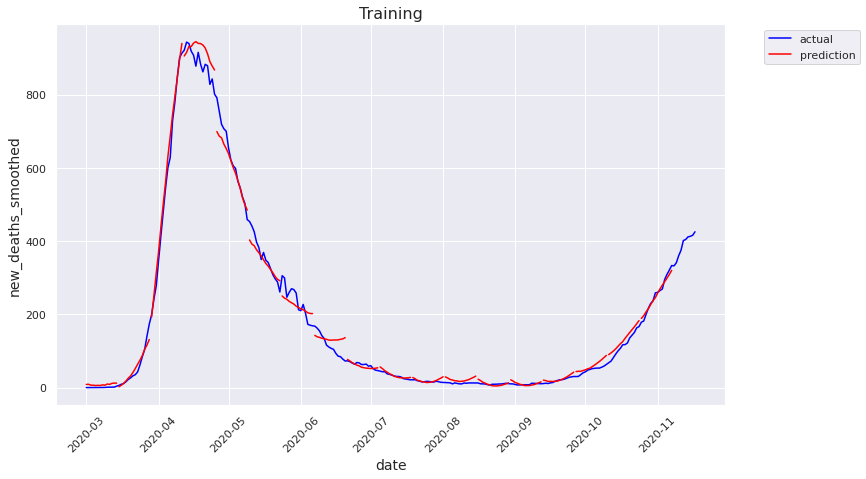

In [28]:
# testy.shape
# model.predict(testX).shape
plot_predictions_vs_actual(inverse_scaling(trainy), inverse_scaling(model.predict(trainX)), train_y_dates, 'Training')

In [29]:
train_mse, train_mae, train_map = print_metrics(model, trainX, trainy)

y's shape is (249, 14)
     mse_error  mae_error  map_error
1   712.914523  18.331394        inf
2   511.676458  15.128451        inf
3   302.014069  11.293576        inf
4   301.244817  10.982327        inf
5   284.739652  10.861884        inf
6   285.273534  10.456122   0.451907
7   322.716912  11.090411   0.338708
8   350.828061  11.604194   0.357584
9   380.470770  12.063115   0.245822
10  403.349255  12.285754   0.238478
11  412.775563  12.272857   0.209814
12  440.031183  12.876213   0.252268
13  613.120598  15.304958   0.290640
14  939.106118  19.360297   0.342196
Mean of mse_errors is 447.1615366285872
Mean of mae_errors is 13.136539492140471
Mean of map_errors is inf


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


target shape is (57,)


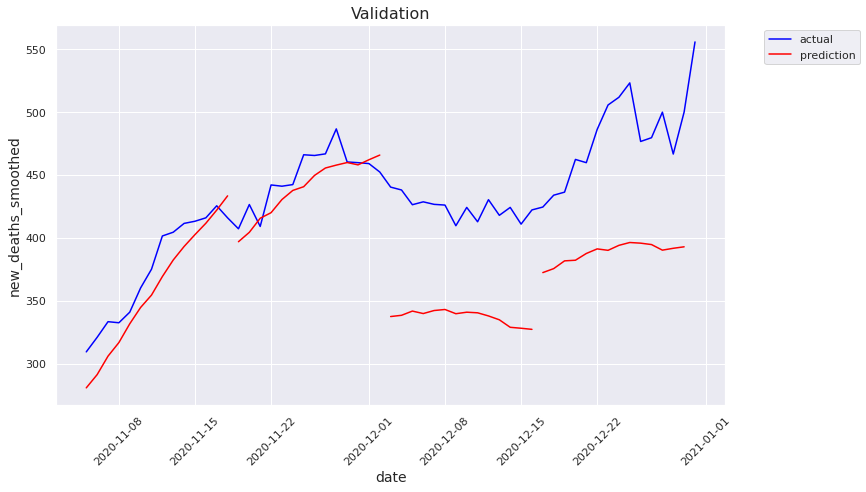

In [30]:
plot_predictions_vs_actual(inverse_scaling(valy), inverse_scaling(model.predict(valX)), val_y_dates, 'Validation')

In [31]:
val_mse, val_mae, val_map = print_metrics(model, valX, valy)

y's shape is (44, 14)
      mse_error  mae_error  map_error
1   5676.168080  69.029614   0.162274
2   5388.441040  67.268904   0.157560
3   4826.988895  63.364924   0.147594
4   4952.370673  64.357922   0.149327
5   4582.696069  61.194859   0.141202
6   4544.354465  60.224675   0.138082
7   5081.887372  62.840334   0.142980
8   5115.824248  60.725340   0.136837
9   5271.302686  58.919763   0.131973
10  5793.816402  60.367516   0.134463
11  6521.324345  62.031785   0.136975
12  7680.925883  66.787173   0.146749
13  8253.672063  67.171082   0.146233
14  9297.971239  71.412089   0.153439
Mean of mse_errors is 5927.695961349016
Mean of mae_errors is 63.978284382213246
Mean of map_errors is 0.1446919875636053


In [32]:
# Reload original weights
model.set_weights(initial_weights)

# Retraining on train + validation set for final test scores
newtrainX = np.concatenate((trainX, valX), axis=0)
newtrainy = np.concatenate((trainy, valy), axis=0)

print(f"trainX shape={newtrainX.shape}")
print(f"trainy shape={newtrainy.shape}")
history = model.fit(newtrainX, newtrainy, validation_data=(testX, testy), epochs=num_epochs, batch_size=batch_size, verbose=1, shuffle=True, callbacks=[es_callback])

trainX shape=(293, 30, 16)
trainy shape=(293, 14)
Epoch 1/75
147/147 [==============================] - 2s 11ms/step - loss: 0.0451 - val_loss: 0.0429
Epoch 2/75
147/147 [==============================] - 1s 6ms/step - loss: 0.0234 - val_loss: 0.0234
Epoch 3/75
147/147 [==============================] - 1s 6ms/step - loss: 0.0148 - val_loss: 0.0240
Epoch 4/75
147/147 [==============================] - 1s 6ms/step - loss: 0.0126 - val_loss: 0.0277
Epoch 5/75
147/147 [==============================] - 1s 6ms/step - loss: 0.0093 - val_loss: 0.0317
Epoch 6/75
147/147 [==============================] - 1s 6ms/step - loss: 0.0098 - val_loss: 0.0331
Epoch 7/75
147/147 [==============================] - 1s 6ms/step - loss: 0.0087 - val_loss: 0.0273
Epoch 8/75
147/147 [==============================] - 1s 6ms/step - loss: 0.0093 - val_loss: 0.0231
Epoch 9/75
147/147 [==============================] - 1s 8ms/step - loss: 0.0086 - val_loss: 0.0335
Epoch 10/75
147/147 [============================

target shape is (96,)


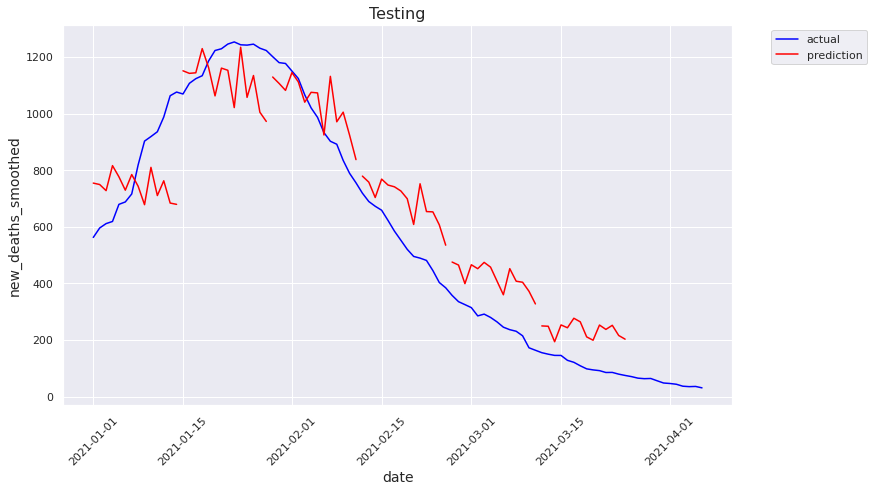

In [33]:
plot_predictions_vs_actual(inverse_scaling(testy), inverse_scaling(model.predict(testX)), test_y_dates, 'Testing')

In [34]:
test_mse, test_mae, test_map = print_metrics(model, testX, testy)

y's shape is (83, 14)
       mse_error   mae_error  map_error
1    8933.188419   82.333928   0.250569
2    7957.196996   80.744107   0.277874
3    3553.808679   52.453187   0.165575
4   12446.664970   99.680075   0.389027
5   10671.287698   90.522386   0.393094
6   20139.465650  134.408340   0.557502
7   17354.088981  118.458447   0.565331
8   15161.615115  115.344483   0.461832
9   20248.808852  127.713228   0.460832
10  35389.234935  169.037580   0.788241
11  31336.570440  168.929582   0.771039
12  32914.612120  173.559334   0.934670
13  39177.765695  182.363751   0.845725
14  36187.735754  166.971330   0.844881
Mean of mse_errors is 20819.431736033992
Mean of mae_errors is 125.89426831275294
Mean of map_errors is 0.5504422222478392


In [35]:
def plot_whatif_predictions(ori_y, max_stringency_y, min_stringency_y, actual_target, dates):
    
    degrees = 45
    target = np.concatenate((actual_target[:,0], actual_target[-1,1:]), axis = 0)
    plt.xticks(rotation=degrees)
    plt.gcf().set_size_inches(12, 7)
    plt.xlabel('date', fontsize=14)
    plt.ylabel(target_var, fontsize=14)
    l1 = plt.plot(dates, target, label='actual', color='blue')
    
    for i in range(0, len(ori_y), next_k_days):
        l2 = plt.plot([dates[i] + datetime.timedelta(days=k) for k in range(next_k_days)], ori_y[i,:], color='red',label='original_prediction' )
    
    for i in range(0, len(max_stringency_y), next_k_days):
        l3 = plt.plot([dates[i] + datetime.timedelta(days=k) for k in range(next_k_days)], max_stringency_y[i,:], color='green', label='max_stringency_prediction')
        
    for i in range(0, len(min_stringency_y), next_k_days):
        l4 = plt.plot([dates[i] + datetime.timedelta(days=k) for k in range(next_k_days)], min_stringency_y[i,:], color='orange', label='min_stringency_prediction')
        

    lns = l1+l2+l3+l4
    labs = [l.get_label() for l in lns]
    plt.gca().legend(lns, labs, bbox_to_anchor=(1.05,1), loc="upper left")

In [36]:
def whatif_quantitative(ori_y, max_stringency_y, min_stringency_y):
    max_ori_diff = np.mean(max_stringency_y - ori_y)
    min_ori_diff = np.mean(min_stringency_y - ori_y)
    
    print(f"Average difference in deaths if stringency was maximum={max_ori_diff}")
    print(f"Average difference in deaths if stringency was minimum={min_ori_diff}")

Average difference in deaths if stringency was maximum=16.309237928467024
Average difference in deaths if stringency was minimum=-37.32779660837516


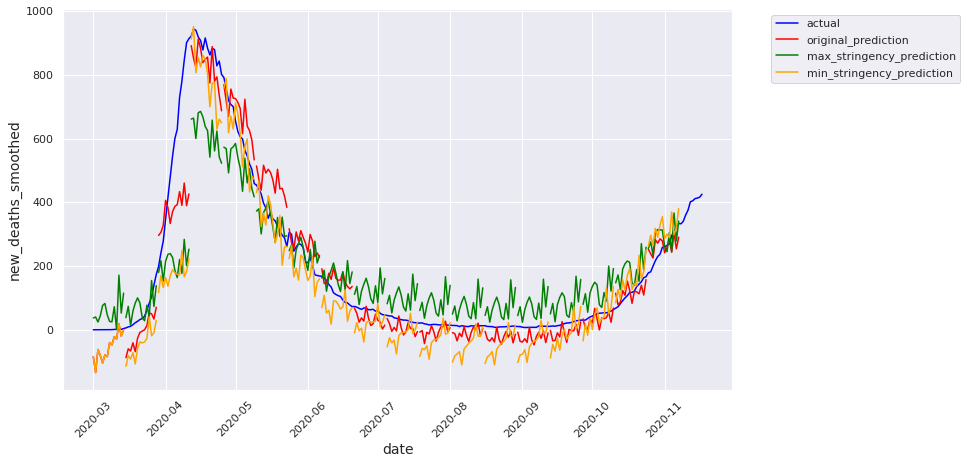

In [37]:
ori_y = inverse_scaling(model.predict(trainX))
max_stringency_y = inverse_scaling(model.predict(train_stringency_max))
min_stringency_y = inverse_scaling(model.predict(train_stringency_min))
actual_target = inverse_scaling(trainy)
plot_whatif_predictions(ori_y, max_stringency_y, min_stringency_y, actual_target, train_y_dates)
whatif_quantitative(ori_y, max_stringency_y, min_stringency_y)

In [38]:
wandb.log({'train_mse':train_mse, 'train_mae':train_mae, 'train_map':train_map, 'val_mse':val_mse, 'val_mae':val_mae, 'val_map':val_map, 'test_mse':test_mse, 'test_mae':test_mae, 'test_map':test_map})